# Лекция №12. Boosting. Gradient Boosting Machine. Ключевые параметры модели.

**Boosting** представляет из себя набор методов, где каждый новый добавленный слабый классификатор учится на ошибках предыдущего классификатора. Таким образом, с добавлением каждого нового классификатора модель совершенствуется. Добавление классификаторов прекращается тогда, когда не имеем значительного (по нашей оценке) прироста в точности модели.

В качестве слабых классификаторов применяются деревья решений. Достоинствами такого выбора являются:  
1) Высокая скорость обучения каждого конкретного дерева;  
2) Отсутсвует необходимость оптимизировать алгоритм, т.к. решение можно выписать в явном виде.

### Алгоритм:

Хотим найти такую функцию f^(x), чтобы минимизировать функцию ошибки:
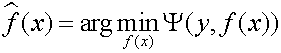

Сначала необходимо проинициализировать первичное предсказание:
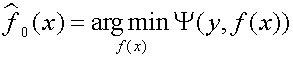

Т.е. найти такое значение этого предсказания, которое минимизирует функцию ошибки на первом шаге.  
Для задачи регрессии это **среднее арифметическое** от всех выходных известных значений обучающей выборки.  
Для задачи классификации (для упрощения для 2-х классов) это логарифм шанса на успех: ```log(m/n) = log(odds)```, где m - число успехов, n - число неудач (другой вариант ```log(p/(1-p))```, где ```p = m/ (m+n)```.

Далее для **каждого дерева** m = 1:M:

1) Посчитать частные производные от функции ошибки (они же остатки, pseudo residuals):
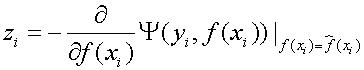

Для задачи регрессии остатки будут равны разности правильного ответа и предсказанного на предыдущем шаге:
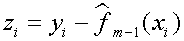

Для задачи классификации остатки будут равны разности предсказанной на предыдущем шаге и истинной вероятностей принадлежать классу:
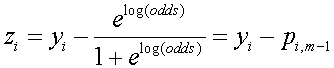

2) Обучить регрессионную модель g(x), которая будет предсказывать $z_i$ по $x_i$, т.е. обучить дерево на полученных остатках

3) Выбрать шаг регрессии модели, исходя из минимизации функции ошибки, поправленной на градиент:
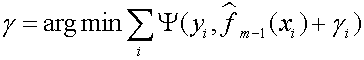

Т.е. посчитать значения в листах получившегося дерева.

Для задачи регрессии это будет **среднее арифметическое** попавший в данных лист значений.

Для задачи классификации значение листа вычисляется по следующей формуле:
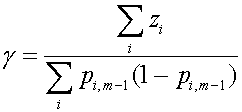

4) Обновить регрессионную модель:
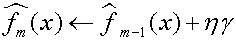

Т.е. пересчитать новые предсказания с учетом нового построенного дерева с поправкой на скорость обучения ```nu```.

Для задачи регрессии необходимо просто сложить по формуле значения предыдущих шагов с полученным на этом шаге (умноженном на скорость обучения), для задач классификации необходимо предварительно перевести значение листьев в вероятности.

Критерий качества (минимизация функции ошибки) рассматривается, исходя из идеи максимизации функции правдоподобия (функция распределения вероятности или плотности вероятности, которая наиболее хорошо описывает наши текущие практические данные).  
Чаще всего это сумма квадратов ошибок (для функции правдоподобия - функции нормального распределения) или сумма модулей ошибок (для функции правдоподобия - функции Лапласа). Однако из других функций правдоподобия можно получить и другие критерии качества.

Результатом Gradient Boosting Machine будет обученная модель, представляющая из себя некоторую линейную комбинацию моделей каждого классификатора:
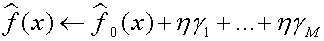
где ```nu``` - это по сути learning rate. Выбор его значения в изначальной статье про GBM основывается только на опытных экспериментах, что стало слабым местом этой модели.

Т.к. модель по сути организует подсчет регрессии, то, если мы решаем задачу классификации, и нам на выходе нужно получить класс, необходимо ввести дополнительные гиперпараметры, которые будут разграничивать выходные непрерывные данные на дискретные классы.

### Gradient Boosting Machine

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Задача: предсказать годовой доход человека (больше или меньше $50000) по информации из переписи населения.  
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
           'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Удаляем столбец Education, т.к. есть дублирующий его закодированный столбец education_num
df = df.drop('education', axis=1)
# Перекодируем отклик (годовой доход) в бинарные значения
df['income'] = df['income'].map({' <=50K':0, ' >50K':1})
# Удаляем строки с пропущенными значениями
df = df.dropna()
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [4]:
test = pd.read_csv('adult.test', header=None, names=columns, skiprows=[0], na_values=' ?')
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.':0, ' >50K.':1})
test = test.dropna()
test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
5,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0


Посчитаем распределение классов в отклике:

In [5]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Считаем, что выборка достаточно сбалансированная.

Разбиваем датасет на обучающую и тестовую выборки. Бинаризуем категориальные признаки:  
Если некоторый признак закодирован категориями, то при другом соответствии чисел категориям модель уже работать не будет. Предлагается перекодировать каждый признак в набор признаков, каждый из которых бинарный и отвечает на вопрос, принадлежит ли признак одному конктерному своему значению или нет.  
Например, в столбце с родной страной у нас закодировано 20 стран. Тогда вместо этого признака создадим 20 признаков, каждый из которых будет обозначать, является ли у опрошенного человека родной страной данная. Таким образом, в 19 столбцах значением будет 0 и только в одном - 1.

In [6]:
x_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']

x_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

После бинаризации категориальных признаков окажется, что в обучающем множестве на один столбец больше, чем будет использоваться для обучения, т.к. в ней не оказалось ни одного человека из Голландии.

In [7]:
print(len(x_train.columns))
print(len(x_test.columns))
# Приводим множества названий колонок к типу set и находим разность двух множеств.
print(set(x_train.columns) - set(x_test.columns))
print(set(x_test.columns) - set(x_train.columns))

88
87
{'native-country_ Holand-Netherlands'}
set()


Чтобы исправить расхождение, создадим полный список всех колонок (из обучающей и из тестовой выборок) и переиндексируем колонки в соответствии с этим списком. В результате в тестовой выборке на месте native-country=Holand-Netherlands появятся NaN, которые мы заменим на нули.

In [8]:
columns = set(x_train.columns|x_test.columns)
x_train = x_train.reindex(columns=columns).fillna(0)
x_test = x_test.reindex(columns=columns).fillna(0)

<ipython-input-8-f61e0109e3fb>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  columns = set(x_train.columns|x_test.columns)


Убедимся в том, что колонки идентичны:

In [9]:
all(x_train.columns == x_test.columns)

True

#### Обучение модели

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=42,
                                  # Число деревьев
                                  n_estimators=100,
                                  # Максимальная глубина каждого дерева
                                  max_depth=3,
                                  # Параметр, уменьшающий переобучение
                                  learning_rate=0.1
                                  )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11360
           1       0.79      0.61      0.69      3700

    accuracy                           0.87     15060
   macro avg       0.84      0.78      0.80     15060
weighted avg       0.86      0.87      0.86     15060

